In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import statsmodels.api as sm

# The time series that you would get are such that the difference between two rows is 15 minutes.
# This is a global number that we used to prepare the data, so you would need it for different purposes.
DATA_RESOLUTION_MIN = 15


class Predictor(object):
    """
    This is where you should implement your predictor.
    The testing script calls the 'predict' function with the glucose and meals test data which you will need in order to
    build your features for prediction.
    You should implement this function as you wish, just do not change the function's signature (name, parameters).
    The other functions are here just as an example for you to have something to start with, you may implement whatever
    you wish however you see fit.
    """

    def __init__(self, path2data):
        """
        This constructor only gets the path to a folder where the training data frames are.
        :param path2data: a folder with your training data.
        """
        self.path2data = path2data
        self.train_glucose = None
        self.train_meals = None
        self.nn = None

    def predict(self, X_glucose, X_meals):
        """
        You must not change the signature of this function!!!
        You are given two data frames: glucose values and meals.
        For every timestamp (t) in X_glucose for which you have at least 12 hours (48 points) of past glucose and two
        hours (8 points) of future glucose, predict the difference in glucose values for the next 8 time stamps
        (t+15, t+30, ..., t+120).

        :param X_glucose: A pandas data frame holding the glucose values in the format you trained on.
        :param X_meals: A pandas data frame holding the meals data in the format you trained on.
        :return: A numpy ndarray, sized (M x 8) holding your predictions for every valid row in X_glucose.
                 M is the number of valid rows in X_glucose (number of time stamps for which you have at least 12 hours
                 of past glucose values and 2 hours of future glucose values.
                 Every row in your final ndarray should correspond to:
                 (glucose[t+15min]-glucose[t], glucose[t+30min]-glucose[t], ..., glucose[t+120min]-glucose[t])
        """

        # build features for set of (ID, timestamp)
        X = self.build_features(X_glucose, X_meals)

        # feed the network you trained (this for example would be a horrible prediction)
        y = pd.concat([X.mean(1) for i in range(8)], axis=1)
        return y

    def define_nn(self):
        """
        Define your neural network.
        :return: None
        """
        self.nn = None
        return

    def train_nn(self, X_train, y_train):
        """
        Train your network using the training data.
        :param X_train: A pandas data frame holding the features
        :param y_train: A numpy ndarray, sized (M x 8) holding the values you need to predict.
        :return:
        """
        pass

    def save_nn_model(self):
        """
        Save your neural network after training.
        :return:
        """
        pass

    def load_nn_model(self):
        """
        Load your trained neural network.
        :return:
        """
        pass

    @staticmethod
    def load_data_frame(path):
        """
        Load a pandas data frame in the relevant format.
        :param path: path to csv.
        :return: the loaded data frame.
        """
        return pd.read_csv(path, index_col=[0, 1], parse_dates=['Date'])



    def build_features(self, X_glucose, X_meals, build_y=False, n_previous_time_points=48):
        """
        Given glucose and meals data, build the features needed for prediction.
        :param X_glucose: A pandas data frame holding the glucose values.
        :param X_meals: A pandas data frame holding the meals data.
        :param build_y: Whether to also extract the values needed for prediction.
        :param n_previous_time_points:
        :return: The features needed for your prediction, and optionally also the relevant y arrays for training.
        """
        # using X_glucose and X_meals to build the features
        # for example just taking the last 2 hours of glucose values
        X = X_glucose.groupby('id').apply(Predictor.create_shifts, n_previous_time_points=n_previous_time_points)

        # this implementation of extracting y is a valid one.
        if build_y:
            y = X_glucose.groupby('id').apply(Predictor.extract_y, n_future_time_points=8)
            X = X.loc[y.index].dropna(how='any', axis=0)
            y = y.loc[X.index].dropna(how='any', axis=0)
            return X, y
        return X

    @staticmethod
    def create_shifts(df, n_previous_time_points=48):
        """
        Creating a data frame with columns corresponding to previous time points
        :param df: A pandas data frame
        :param n_previous_time_points: number of previous time points to shift
        :return:
        """
        for g, i in zip(range(DATA_RESOLUTION_MIN, DATA_RESOLUTION_MIN*(n_previous_time_points+1), DATA_RESOLUTION_MIN),
                        range(1, (n_previous_time_points+1), 1)):
            df['GlucoseValue -%0.1dmin' % g] = df.GlucoseValue.shift(i)
        return df.dropna(how='any', axis=0)

    @staticmethod
    def extract_y(df, n_future_time_points=8):
        """
        Extracting the m next time points (difference from time zero)
        :param n_future_time_points: number of future time points
        :return:
        """
        for g, i in zip(range(DATA_RESOLUTION_MIN, DATA_RESOLUTION_MIN*(n_future_time_points+1), DATA_RESOLUTION_MIN),
                        range(1, (n_future_time_points+1), 1)):
            df['Glucose difference +%0.1dmin' % g] = df.GlucoseValue.shift(-i) - df.GlucoseValue
        return df.dropna(how='any', axis=0).drop('GlucoseValue', axis=1)

    
    def load_raw_data(self):
        """
        Loads raw data frames from csv files, and do some basic cleaning
        :return:
        """
        self.train_glucose = Predictor.load_data_frame(os.path.join(self.path2data, 'GlucoseValues.csv'))
        self.train_meals = Predictor.load_data_frame(os.path.join(self.path2data, 'Meals.csv'))

                # suggested procedure
        # 1. handle outliers: trimming, clipping..
        # 2. feature normalizations
        # 3. resample meals data to match glucose values intervals
        
        
        outlier_std = 4

        # remove glucose outlier_std std above the mean
        # get standard score
        self.train_glucose = normelize_df(predictor.train_glucose)
        # remove outlier_std std above and below mean
        self.train_glucose = predictor.train_glucose[predictor.train_glucose.abs()<outlier_std]
        # renormelize after removing outliers
        self.train_glucose = normelize_df(predictor.train_glucose)
        self.train_meals
        
        # remove outliers from meals 
        no_zero_meals = self.train_meals.replace(0, np.NaN)
        outlier_th = no_zero_meals.groupby('id').mean() + outlier_std * no_zero_meals.groupby('id').std() 
        self.train_meals[predictor.train_meals-outlier_th<0]
        
        # resample meals by glucose sample time
        resample_time = str(DATA_RESOLUTION_MIN)+'T'
        self.train_meals = self.train_meals.groupby(pd.Grouper(level=0)).resample(resample_time,level=-1).sum()

        # remove meals outlier_std std above the mean
        # get standard score
        self.train_meals = self.train_meals/self.train_meals.groupby('id').max()

        self.train_glucose = self.train_glucose.groupby(pd.Grouper(level=0)).resample(resample_time,level=-1).first()

        # replace nan meal values for 0 and nan glucose data with qubic interpulation
        self.train_meals = self.train_meals.fillna(0)
        self.train_glucose = self.train_glucose.interpolate()
        
        # now merge the glucose and meas dataframes on the same time stamps
        self.cgm_and_meals_id_time = self.train_glucose.merge(predictor.train_meals,how='left',left_index=True,right_index=True)
        self.cgm_and_meals_id_time = self.cgm_and_meals_id_time.fillna(0)
        #self.cgm_and_meals_id_time.isnull().sum()

        return 

def normelize_df(df):
    #predictor.train_meals.loc[3888]
    # 1. find the mean and std per id
    id_df_mean = df.groupby('id').mean()
    id_df_std = df.groupby('id').std()

    # remove 2 std above the mean
    # get standard score
    df = (df-id_df_mean)/id_df_std
    
    return df

In [2]:
if __name__ == "__main__":
    # example of predict() usage

    # create Predictor instance
    path2data = ''
    predictor = Predictor(path2data)
    
    # load the raw data
    predictor.load_raw_data()

In [3]:
def univariate_data(dataset, start_index, end_index, history_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(dataset[indices])
  return np.array(data)

In [43]:

def pre_process_train_across(predictor, ids,k):

    x_all = np.empty([1,k])
    y_all = np.empty([1])

    for id in ids:
        data = predictor.cgm_and_meals_id_time.loc[id]
        end_index = len(data)
        x_single = univariate_data(data.GlucoseValue.values, 0,end_index,k)
        if id==46:
            print(x_single.shape)
        x_all = np.append(x_all,x_single,axis=0)
        
        y_single = predictor.cgm_and_meals_id_time['food_id'].loc[id]>0
        y_single = y_single.values[k:]
        y_all = np.append(y_all,y_single,axis=0)
    
    return x_all, y_all


In [42]:
k=20 # prediction history
ids_all = predictor.cgm_and_meals_id_time.reset_index()['id'].unique()

ids_train = ids_all[0:round(len(ids_all)*0.8)]
ids_CV = ids_all[-round(len(ids_all)*0.2):]
x_train_all, y_train_all = pre_process_train_across(predictor, ids_train,k)
x_CV_all, y_CV_all = pre_process_train_across(predictor, ids_CV,k)


# check backward prediction
x_train_all = x_train_all[]

[[ 0.31410774  0.16347296 -0.13779658 ...  0.69069467 -0.28843135
  -0.96628783]
 [ 0.16347296 -0.13779658 -0.21311397 ... -0.28843135 -0.96628783
  -1.34287476]
 [-0.13779658 -0.21311397 -0.0624792  ... -0.96628783 -1.34287476
  -0.96628783]
 ...
 [-0.96628783 -0.81565306 -0.51438351 ... -0.13779658  0.23879035
   0.23879035]
 [-0.81565306 -0.51438351 -0.43906613 ...  0.23879035  0.23879035
  -0.13779658]
 [-0.51438351 -0.43906613 -0.51438351 ...  0.23879035 -0.13779658
  -0.51438351]]


In [76]:
x_train_all.shape

(682421, 20)

In [18]:
x_train_model = sm.add_constant(x_train_all)
binomial_model = sm.GLM(y_train_all, x_train_model, family=sm.families.Binomial())
binomial_results = binomial_model.fit()



In [19]:
print(binomial_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               682421
Model:                            GLM   Df Residuals:                   682400
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6267e+05
Date:                Mon, 24 Feb 2020   Deviance:                   3.2535e+05
Time:                        10:26:08   Pearson chi2:                 6.82e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6845      0.005   -539.709      0.0

In [20]:
x_CV_model = sm.add_constant(x_CV_all)
predicted_train_values = binomial_results.predict(x_train_model)
predicted_values = binomial_results.predict(x_CV_model)

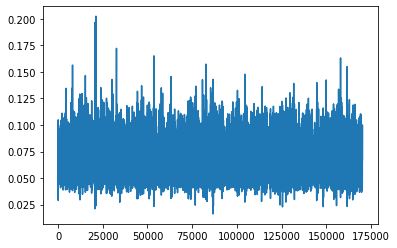

In [22]:
plt.plot(predicted_values)

In [23]:
np.corrcoef(predicted_values,y_CV_all)


array([[1.        , 0.02867173],
       [0.02867173, 1.        ]])

In [24]:
np.corrcoef(predicted_train_values,y_train_all)

array([[1.        , 0.03938399],
       [0.03938399, 1.        ]])

In [70]:
predicted_meal = predicted_values>0.08

In [80]:
x_train_all.shape

(682421, 20)

In [88]:
meal_glu_val = x_train_all[y_train_all>0,:]
no_meal_glu_val = x_train_all[y_train_all<1,:]


(array([5.62806184e-05, 0.00000000e+00, 5.62806184e-05, 5.62806184e-05,
        1.12561237e-04, 1.68841855e-04, 1.68841855e-04, 5.62806184e-05,
        5.62806184e-05, 1.68841855e-04, 5.62806184e-05, 2.81403092e-04,
        3.93964329e-04, 5.62806184e-05, 1.68841855e-04, 1.68841855e-04,
        3.93964329e-04, 3.37683711e-04, 6.75367421e-04, 5.06525566e-04,
        3.93964329e-04, 5.06525566e-04, 4.50244947e-04, 5.62806184e-04,
        7.31648039e-04, 2.30750536e-03, 3.93964329e-04, 1.01305113e-03,
        5.62806184e-04, 1.40701546e-03, 1.23817361e-03, 9.56770513e-04,
        1.40701546e-03, 1.12561237e-03, 2.36378597e-03, 3.48939834e-03,
        1.91354103e-03, 1.85726041e-03, 4.33360762e-03, 7.03507730e-03,
        6.69739359e-03, 5.74062308e-03, 4.55873009e-03, 4.05220453e-03,
        3.82708205e-03, 4.27732700e-03, 2.81403092e-03, 4.33360762e-03,
        4.55873009e-03, 3.77080143e-03, 4.55873009e-03, 3.88336267e-03,
        4.38988824e-03, 3.88336267e-03, 7.48532225e-03, 5.740623

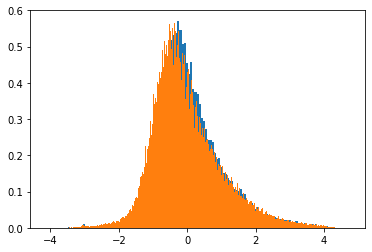

In [92]:
np.histogram(meal_glu_val[:,19])
plt.hist(meal_glu_val[:,19], bins='auto',density=True)
plt.hist(no_meal_glu_val[:,19], bins='auto',density=True)


(array([5.62806184e-05, 0.00000000e+00, 5.62806184e-05, 5.62806184e-05,
        1.12561237e-04, 1.12561237e-04, 1.68841855e-04, 5.62806184e-05,
        5.62806184e-05, 1.68841855e-04, 5.62806184e-05, 2.81403092e-04,
        3.93964329e-04, 5.62806184e-05, 1.68841855e-04, 1.68841855e-04,
        3.93964329e-04, 3.37683711e-04, 6.75367421e-04, 5.06525566e-04,
        3.37683711e-04, 5.06525566e-04, 4.50244947e-04, 5.62806184e-04,
        7.87928658e-04, 2.36378597e-03, 3.37683711e-04, 9.56770513e-04,
        5.62806184e-04, 1.40701546e-03, 1.23817361e-03, 1.06933175e-03,
        1.46329608e-03, 1.12561237e-03, 2.30750536e-03, 3.48939834e-03,
        1.91354103e-03, 1.85726041e-03, 4.38988824e-03, 7.03507730e-03,
        6.75367421e-03, 5.68434246e-03, 4.67129133e-03, 3.93964329e-03,
        3.88336267e-03, 4.16476576e-03, 2.92659216e-03, 4.33360762e-03,
        4.61501071e-03, 3.71452082e-03, 4.38988824e-03, 3.48939834e-03,
        4.50244947e-03, 3.82708205e-03, 7.54160287e-03, 5.740623

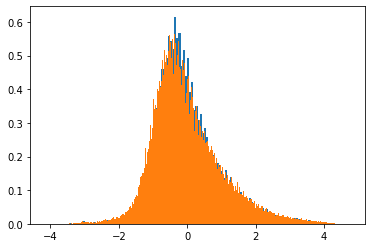

In [96]:
plt.hist(meal_glu_val[:,18], bins='auto',density=True)
plt.hist(no_meal_glu_val[:,18], bins='auto',density=True)

(array([5.64564954e-05, 0.00000000e+00, 5.64564954e-05, 5.64564954e-05,
        1.12912991e-04, 1.12912991e-04, 1.69369486e-04, 5.64564954e-05,
        5.64564954e-05, 1.69369486e-04, 5.64564954e-05, 2.25825981e-04,
        4.51651963e-04, 5.64564954e-05, 1.69369486e-04, 1.69369486e-04,
        3.95195467e-04, 3.38738972e-04, 6.77477944e-04, 5.08108458e-04,
        3.95195467e-04, 5.64564954e-04, 3.95195467e-04, 3.95195467e-04,
        8.46847430e-04, 2.25825981e-03, 3.38738972e-04, 1.12912991e-03,
        6.21021449e-04, 1.24204290e-03, 1.29849939e-03, 1.01621692e-03,
        1.29849939e-03, 1.29849939e-03, 2.08889033e-03, 3.66967220e-03,
        1.75015136e-03, 1.52432537e-03, 3.50030271e-03, 7.56517038e-03,
        6.21021449e-03, 6.09730150e-03, 5.02462809e-03, 3.61321570e-03,
        4.29069365e-03, 3.72612869e-03, 2.93573776e-03, 4.23423715e-03,
        4.57297612e-03, 4.00841117e-03, 4.34715014e-03, 3.33093323e-03,
        4.68588911e-03, 3.44384622e-03, 6.77477944e-03, 5.984388

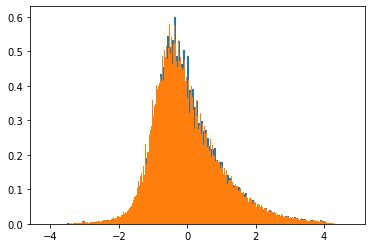

In [100]:
plt.hist(meal_glu_val[:,15], bins='auto',density=True)
plt.hist(no_meal_glu_val[:,15], bins='auto',density=True)

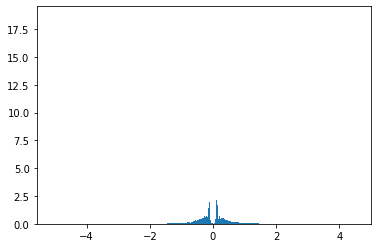

In [121]:
tmp = plt.hist(no_meal_glu_val[:,1]-no_meal_glu_val[:,0], bins='auto',density=True)

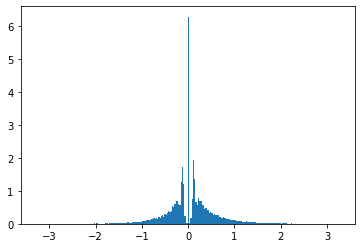

In [120]:
tmp = plt.hist(meal_glu_val[:,19]-meal_glu_val[:,18], bins='auto',density=True)


In [122]:
sum(meal_glu_val[:,1]-meal_glu_val[:,0] == 0)

8399

In [125]:
sum(meal_glu_val[:,1] == meal_glu_val[:,0])

8399

In [126]:
a = True
if a:
    b=2
    
b

2